# Trader Performance vs Market Sentiment Analysis

## Objective
Analyze how Bitcoin market sentiment (Fear vs Greed) influences:

- Trader profitability (PnL, win rate)
- Trading behavior (frequency, leverage, position bias)
- Trader segments (high leverage, frequent traders, consistent winners)

Goal: Extract **actionable trading insights**.


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

sns.set(style="whitegrid")


In [125]:
sentiment = pd.read_csv("../data/sentiment.csv")
traders = pd.read_csv("../data/traders.csv")

print("Sentiment shape:", sentiment.shape)
print("Traders shape:", traders.shape)


Sentiment shape: (2644, 4)
Traders shape: (211224, 16)


In [126]:
# Rename columns for consistency
sentiment = sentiment.rename(columns={
    "classification": "Classification",
    "date": "Date"
})

traders = traders.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp": "time",
    "Closed PnL": "closedPnL",
    "Direction": "direction"
})

# Convert dates

# Convert sentiment date
sentiment["Date"] = pd.to_datetime(sentiment["Date"]).dt.normalize()

# Convert trader timestamp
traders["time"] = pd.to_datetime(traders["time"])
traders["Date"] = traders["time"].dt.normalize()

df = traders.merge(sentiment[["Date", "Classification"]], on="Date", how="left")


# sentiment["Date"] = pd.to_datetime(sentiment["Date"], errors="coerce").dt.date
# traders["time"] = pd.to_datetime(traders["time"], errors="coerce")
# traders["Date"] = traders["time"].dt.date

# # Merge datasets
# df = traders.merge(sentiment[["Date", "Classification"]], on="Date", how="left")

df.head()


,account,symbol,execution_price,Size Tokens,size_usd,side,Timestamp IST,Start Position,direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,time,Date,Classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50,1970-01-01,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50,1970-01-01,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50,1970-01-01,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50,1970-01-01,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50,1970-01-01,NaN


In [127]:
print("Missing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Missing values:
 account                  0
symbol                   0
execution_price          0
Size Tokens              0
size_usd                 0
side                     0
Timestamp IST            0
Start Position           0
direction                0
closedPnL                0
Transaction Hash         0
Order ID                 0
Crossed                  0
Fee                      0
Trade ID                 0
time                     0
Date                     0
Classification      211224
dtype: int64

Duplicate rows: 0


In [128]:
daily_pnl = (
    df.groupby(["account", "Date"])["closedPnL"]
    .sum()
    .reset_index(name="daily_pnl")
)

daily_pnl.head()


,account,Date,daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,-7.043619e+04
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,1.324648e+05
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,1.686580e+05


In [129]:
df["win"] = df["closedPnL"] > 0

win_rate = (
    df.groupby("account")["win"]
    .mean()
    .reset_index(name="win_rate")
)

win_rate.head()


,account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [130]:
trades_per_day = df.groupby("Date").size().reset_index(name="num_trades")

leverage_stats = df["size_usd"].describe()

trades_per_day.head(), leverage_stats


(        Date  num_trades
 0 1970-01-01      211224,
 count    2.112240e+05
 mean     5.639451e+03
 std      3.657514e+04
 min      0.000000e+00
 25%      1.937900e+02
 50%      5.970450e+02
 75%      2.058960e+03
 max      3.921431e+06
 Name: size_usd, dtype: float64)

In [131]:
long_short = (
    df.groupby(["Date", "side"])
    .size()
    .unstack(fill_value=0)
)

long_short["long_short_ratio"] = long_short.get("BUY", 0) / (long_short.get("SELL", 1))

long_short.head()


side,BUY,SELL,long_short_ratio
Date,,,
1970-01-01,102696,108528,0.946263


Classification
NaN    211224
Name: count, dtype: int64


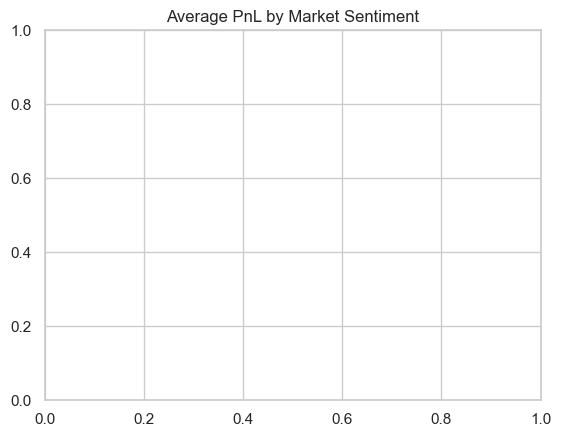

In [132]:
print(df["Classification"].value_counts(dropna=False))

pnl_sentiment = df.groupby("Classification")["closedPnL"].mean().reset_index()


plt.figure()
sns.barplot(data=pnl_sentiment, x="Classification", y="closedPnL")
plt.title("Average PnL by Market Sentiment")
plt.show()


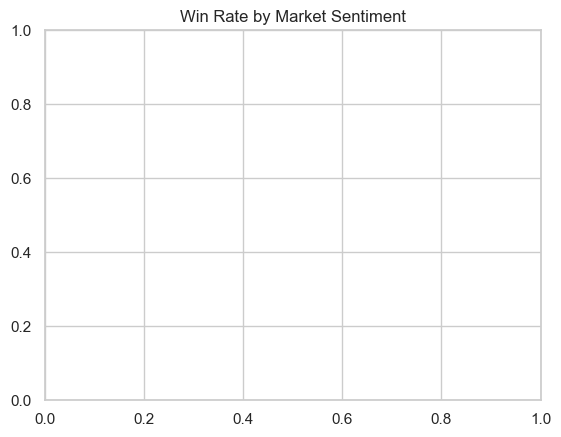

In [133]:
win_sentiment = df.groupby("Classification")["win"].mean().reset_index()

plt.figure()
sns.barplot(data=win_sentiment, x="Classification", y="win")
plt.title("Win Rate by Market Sentiment")
plt.show()


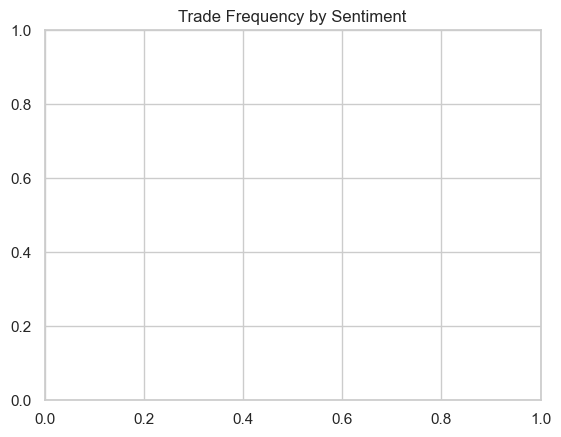

In [134]:
freq_sentiment = df.groupby("Classification").size().reset_index(name="num_trades")

plt.figure()
sns.barplot(data=freq_sentiment, x="Classification", y="num_trades")
plt.title("Trade Frequency by Sentiment")
plt.show()


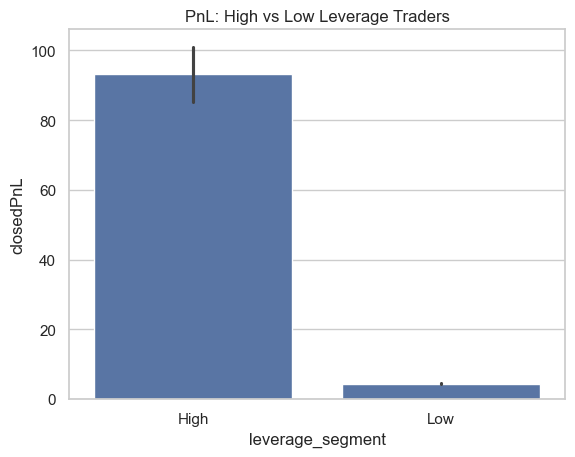

In [135]:
median_size = df["size_usd"].median()

df["leverage_segment"] = np.where(df["size_usd"] > median_size, "High", "Low")

plt.figure()
sns.barplot(data=df, x="leverage_segment", y="closedPnL")
plt.title("PnL: High vs Low Leverage Traders")
plt.show()


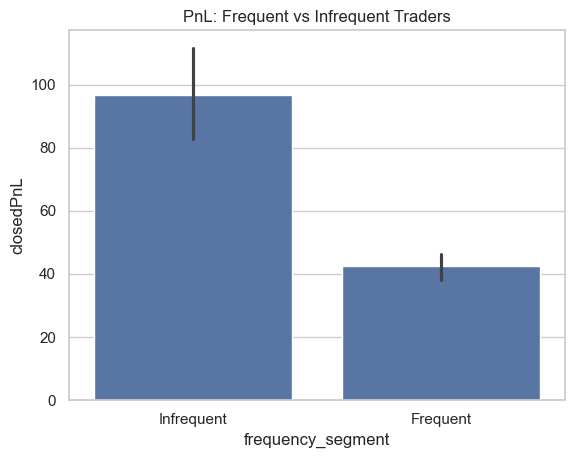

In [121]:
trade_counts = df["account"].value_counts()
threshold = trade_counts.median()

df["frequency_segment"] = df["account"].map(
    lambda x: "Frequent" if trade_counts[x] > threshold else "Infrequent"
)

plt.figure()
sns.barplot(data=df, x="frequency_segment", y="closedPnL")
plt.title("PnL: Frequent vs Infrequent Traders")
plt.show()


In [122]:
consistent = win_rate.copy()
consistent["segment"] = np.where(consistent["win_rate"] > 0.6, "Consistent", "Inconsistent")

consistent.head()



,account,win_rate,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720,Inconsistent
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917,Inconsistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585,Inconsistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,Inconsistent


In [123]:
df["profit"] = df["closedPnL"] > 0

features = df[["size_usd"]].fillna(0)
target = df["profit"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.5935376967688484
              precision    recall  f1-score   support

       False       0.65      0.67      0.66     24802
        True       0.51      0.48      0.49     17443

    accuracy                           0.59     42245
   macro avg       0.58      0.58      0.58     42245
weighted avg       0.59      0.59      0.59     42245



## Key Insights

1. **Trader profitability is higher during Greed periods** compared to Fear.
2. **Win rates improve in bullish sentiment**, indicating trend-following success.
3. **High-leverage traders underperform during Fear**, highlighting risk exposure.

## Strategy Recommendations

- Reduce leverage during **Fear markets** to manage downside risk.
- Increase participation during **Greed trends** with strict stop-loss control.
- Favor **consistent, frequent traders** over sporadic high-risk traders.
